#### Install required libraries

In [5]:
# ! pip install tensorflow_datasets
# ! pip install tensorflow
# ! pip install torch-summary

### PyTorch - Training GoogLeNet on CIFAR-10

#### Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from torchvision import models
from torchsummary import summary
from torchvision.datasets import CIFAR10
import torch.utils.data as data
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sb
from torch.optim import lr_scheduler
import time, os, copy
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, precision_score, f1_score


#### Setting pre-requisites

In [2]:
# Function for setting the seed
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU: ', device)
else:
  device = torch.device('cpu')
  print('Running on the CPU')

set_seed(24)

Running on the GPU:  cuda:0


#### Load dataset with normalization

In [3]:
PATH = "../data"

train_dataset = CIFAR10(root=PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [4]:
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])
                                     
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])

# Loading the training dataset and splitting it into a training and validation sets
train_dataset = CIFAR10(root=PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_ , val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# defining dataset size of training and validation sets
dataset_sizes = [len(train_set), len(val_set)]
# defining classes in the dataset
class_names = train_dataset.classes

#### Data Visualization

In [6]:
def show_image(input_image, title=None):
    input_image = input_image.numpy().transpose((1, 2, 0))
    mean = np.array([DATA_MEANS])
    std = np.array([DATA_STD])
    input_image = std * input_image + mean
    input_image = np.clip(input_image, 0, 1)
    plt.imshow(input_image)
    if title is not None:
        plt.title(title)
    plt.pause(0.005)  # Pause a bit so that plots are updated

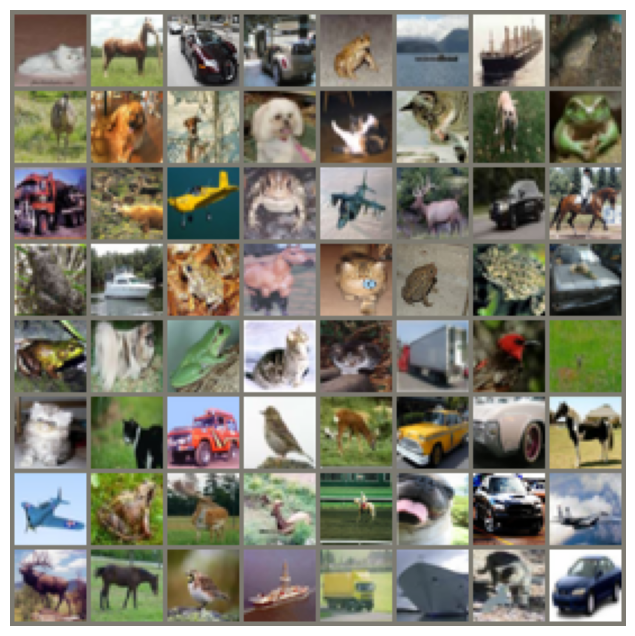

In [8]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
plt.figure(figsize=(16,8))
plt.axis('off')
out = torchvision.utils.make_grid(inputs)
show_image(out)

#### Defining Pretrained Model

In [7]:
GoogLeNet = models.googlenet(weights='GoogLeNet_Weights.DEFAULT')
num_features = GoogLeNet.fc.in_features
GoogLeNet.fc = nn.Linear(num_features, 10) # adding a final layer for multiclass classification on CIFAR10

# print("The model summary is as follows: \n")
# summary(GoogLeNet, (3, 32, 32), verbose=2, col_names=["kernel_size", "output_size", "num_params"])

GoogLeNet = GoogLeNet.to(device) # model is hosted on GPU for further computation

#### Model Training - Functions and hyperparameter defintion

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    training_loss = []
    validation_loss = []
    training_acc = []
    validation_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloaders = train_loader
                index = 0
                optimizer.step()
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloaders = val_loader
                index = 1
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            # print('Iterating through data...')

            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[index]
            epoch_acc = current_corrects.double() / dataset_sizes[index]

            if phase == 'train':
                training_loss.append(epoch_loss)
                training_acc.append(epoch_acc)
            else: # when phase = 'valid'
                validation_loss.append(epoch_loss)
                validation_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)

    return model, (training_loss, training_acc, validation_loss, validation_acc)

#### Visualize Image Predictions Function

In [9]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                show_image(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Training and Validation

###### Model 1: Nestrov Momemntum = False, Gamma = 0.1, step_size = 7, lr =0.001, momentum=0.9

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(GoogLeNet.parameters(), lr=0.001, momentum=0.9)

decay_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [83]:
base_model = train_model(GoogLeNet, criterion, optimizer, decay_lr_scheduler, num_epochs=30)

Epoch 0/99
----------
train Loss: 1.7657 Acc: 0.3801
val Loss: 1.2641 Acc: 0.5620

Epoch 1/99
----------
train Loss: 1.1029 Acc: 0.6102
val Loss: 0.9973 Acc: 0.6550

Epoch 2/99
----------
train Loss: 0.8761 Acc: 0.6903
val Loss: 0.8908 Acc: 0.6880

Epoch 3/99
----------
train Loss: 0.7375 Acc: 0.7393
val Loss: 0.8346 Acc: 0.7094

Epoch 4/99
----------
train Loss: 0.6302 Acc: 0.7783
val Loss: 0.8134 Acc: 0.7188

Epoch 5/99
----------
train Loss: 0.5411 Acc: 0.8101
val Loss: 0.8148 Acc: 0.7250

Epoch 6/99
----------
train Loss: 0.4501 Acc: 0.8442
val Loss: 0.8100 Acc: 0.7266

Epoch 7/99
----------
train Loss: 0.4325 Acc: 0.8494
val Loss: 0.8180 Acc: 0.7290

Epoch 8/99
----------
train Loss: 0.4213 Acc: 0.8545
val Loss: 0.8161 Acc: 0.7328

Epoch 9/99
----------
train Loss: 0.4140 Acc: 0.8570
val Loss: 0.8203 Acc: 0.7274

Epoch 10/99
----------
train Loss: 0.3993 Acc: 0.8619
val Loss: 0.8192 Acc: 0.7286

Epoch 11/99
----------
train Loss: 0.3959 Acc: 0.8643
val Loss: 0.8289 Acc: 0.7272

Ep

KeyboardInterrupt: 

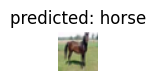

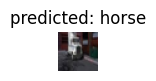

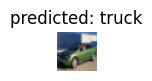

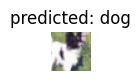

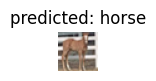

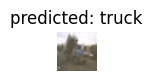

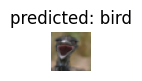

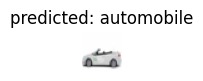

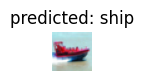

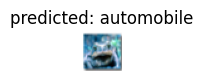

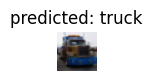

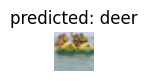

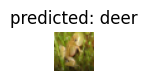

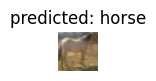

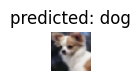

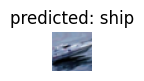

In [84]:
visualize_model(base_model, num_images = 16)
plt.show()

###### Model 2: Nestrov Momemntum = True, Gamma = 0.1, step_size = 7, lr =0.001, momentum=0.9

In [19]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(GoogLeNet.parameters(), lr=0.001, momentum=0.9, nesterov=True)

decay_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [20]:
model_iter2, loss_acc_iter2 = train_model(GoogLeNet, criterion, optimizer, decay_lr_scheduler, num_epochs=35)

Epoch 0/34
----------
train Loss: 1.4710 Acc: 0.4816
val Loss: 0.9145 Acc: 0.6890
Epoch 1/34
----------
train Loss: 0.9131 Acc: 0.6839
val Loss: 0.6681 Acc: 0.7760
Epoch 2/34
----------
train Loss: 0.7345 Acc: 0.7457
val Loss: 0.5323 Acc: 0.8240
Epoch 3/34
----------
train Loss: 0.6127 Acc: 0.7882
val Loss: 0.4326 Acc: 0.8556
Epoch 4/34
----------
train Loss: 0.5176 Acc: 0.8176
val Loss: 0.3488 Acc: 0.8874
Epoch 5/34
----------
train Loss: 0.4420 Acc: 0.8473
val Loss: 0.2842 Acc: 0.9130
Epoch 6/34
----------
train Loss: 0.3473 Acc: 0.8813
val Loss: 0.2568 Acc: 0.9234
Epoch 7/34
----------
train Loss: 0.3251 Acc: 0.8905
val Loss: 0.2458 Acc: 0.9262
Epoch 8/34
----------
train Loss: 0.3120 Acc: 0.8931
val Loss: 0.2323 Acc: 0.9332
Epoch 9/34
----------
train Loss: 0.3024 Acc: 0.8988
val Loss: 0.2240 Acc: 0.9346
Epoch 10/34
----------
train Loss: 0.2959 Acc: 0.8977
val Loss: 0.2190 Acc: 0.9394
Epoch 11/34
----------
train Loss: 0.2846 Acc: 0.9026
val Loss: 0.2084 Acc: 0.9432
Epoch 12/34
--

In [ ]:
train_accuracy = []
for i in range(len(loss_acc_iter2[1])):
    loss_acc_iter2[1][i] = loss_acc_iter2[1][i].cpu()
    loss_acc_iter2[1][i] = loss_acc_iter2[1][i].numpy()
    train_accuracy.append(loss_acc_iter2[1][i])
train_accuracy

In [ ]:
validation_accuracy = []
for i in range(len(loss_acc_iter2[3])):
    loss_acc_iter2[3][i] = loss_acc_iter2[3][i].cpu()
    loss_acc_iter2[3][i] = loss_acc_iter2[3][i].numpy()
    validation_accuracy.append(loss_acc_iter2[1][i])
validation_accuracy

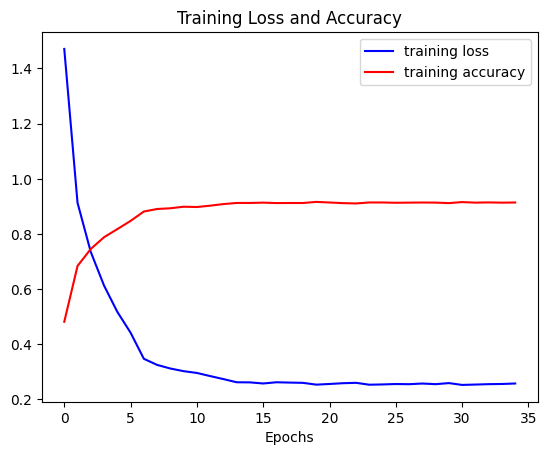

In [46]:
r"""Plotting validation loss and accuracy"""

x = range(0, len(loss_acc_iter2[0]))
y1 = loss_acc_iter2[0]
y2 = train_accuracy

r"""loss_acc_iter2: training_loss, training_acc, validation_loss, validation_acc"""

plt.plot(x, y1, color='blue') #training loss
plt.plot(x, y2, color='red') #training accuracy
plt.title('Training Loss and Accuracy') #title
plt.xlabel('Epochs') # x label
plt.legend(['training loss','training accuracy'])
plt.show()

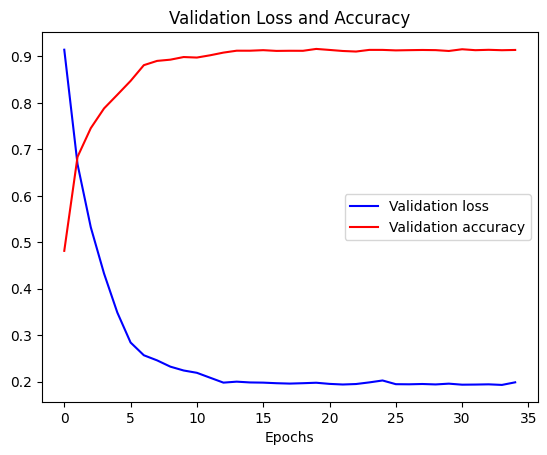

In [49]:
r"""Plotting validation loss and accuracy"""

x = range(0, len(loss_acc_iter2[0]))
y1 = loss_acc_iter2[2]
y2 = validation_accuracy

r"""loss_acc_iter2: training_loss, training_acc, validation_loss, validation_acc"""

plt.plot(x, y1, color='blue') #training loss
plt.plot(x, y2, color='red') #training accuracy
plt.title('Validation Loss and Accuracy') #title
plt.xlabel('Epochs') # x label
plt.legend(['Validation loss','Validation accuracy'])
plt.show()

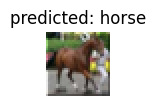

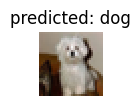

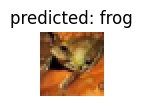

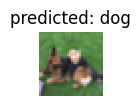

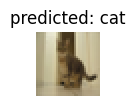

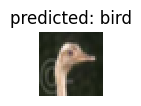

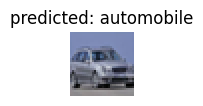

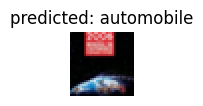

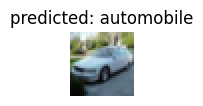

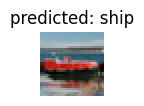

In [26]:
visualize_model(model_iter2, num_images = 10)
plt.show()

###### Model 3: NAdam Optimizer with Gamma = 0.1, step_size = 7,lr=0.0001, weight_decay = 0.01, momentum_decay  = 0.002

In [28]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(GoogLeNet.parameters(), lr=0.0001, weight_decay = 0.01, momentum_decay  = 0.002)

decay_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [29]:
model_iter3, loss_acc_iter3 = train_model(GoogLeNet, criterion, optimizer, decay_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2634 Acc: 0.5606
val Loss: 0.7092 Acc: 0.7620
Epoch 1/24
----------
train Loss: 0.7312 Acc: 0.7482
val Loss: 0.4858 Acc: 0.8444
Epoch 2/24
----------
train Loss: 0.5514 Acc: 0.8119
val Loss: 0.3645 Acc: 0.8890
Epoch 3/24
----------
train Loss: 0.4410 Acc: 0.8513
val Loss: 0.2934 Acc: 0.9102
Epoch 4/24
----------
train Loss: 0.3636 Acc: 0.8760
val Loss: 0.2394 Acc: 0.9274
Epoch 5/24
----------
train Loss: 0.3112 Acc: 0.8969
val Loss: 0.2104 Acc: 0.9364
Epoch 6/24
----------
train Loss: 0.1739 Acc: 0.9504
val Loss: 0.1253 Acc: 0.9676
Epoch 7/24
----------
train Loss: 0.1193 Acc: 0.9680
val Loss: 0.1014 Acc: 0.9772
Epoch 8/24
----------
train Loss: 0.0933 Acc: 0.9751
val Loss: 0.0879 Acc: 0.9800
Epoch 9/24
----------
train Loss: 0.0755 Acc: 0.9805
val Loss: 0.0830 Acc: 0.9812
Epoch 10/24
----------
train Loss: 0.0619 Acc: 0.9851
val Loss: 0.0799 Acc: 0.9822
Epoch 11/24
----------
train Loss: 0.0537 Acc: 0.9872
val Loss: 0.0803 Acc: 0.9826
Epoch 12/24
--

In [30]:
train_accuracy = []
for i in range(len(loss_acc_iter3[1])):
    loss_acc_iter3[1][i] = loss_acc_iter3[1][i].cpu()
    loss_acc_iter3[1][i] = loss_acc_iter3[1][i].numpy()
    train_accuracy.append(loss_acc_iter3[1][i])
train_accuracy

validation_accuracy = []
for i in range(len(loss_acc_iter3[3])):
    loss_acc_iter3[3][i] = loss_acc_iter3[3][i].cpu()
    loss_acc_iter3[3][i] = loss_acc_iter3[3][i].numpy()
    validation_accuracy.append(loss_acc_iter3[1][i])
validation_accuracy

[array(0.56057778),
 array(0.74817778),
 array(0.81193333),
 array(0.85128889),
 array(0.87602222),
 array(0.89691111),
 array(0.9504),
 array(0.96802222),
 array(0.97513333),
 array(0.98046667),
 array(0.98513333),
 array(0.98715556),
 array(0.98997778),
 array(0.99213333),
 array(0.99273333),
 array(0.99266667),
 array(0.993),
 array(0.99422222),
 array(0.99475556),
 array(0.99373333),
 array(0.99484444),
 array(0.99555556),
 array(0.99493333),
 array(0.99511111),
 array(0.99497778)]

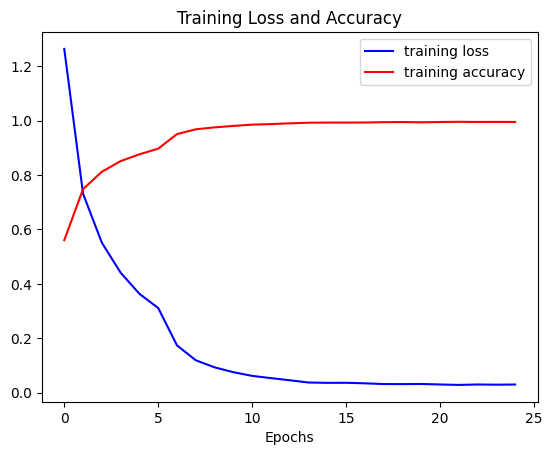

In [32]:
r"""Plotting validation loss and accuracy"""

x = range(0, len(loss_acc_iter3[0]))
y1 = loss_acc_iter3[0]
y2 = train_accuracy

r"""loss_acc_iter3: training_loss, training_acc, validation_loss, validation_acc"""
plt.plot(x, y1, color='blue') #training loss
plt.plot(x, y2, color='red') #training accuracy
plt.title('Training Loss and Accuracy') #title
plt.xlabel('Epochs') # x label
plt.legend(['training loss','training accuracy'])
plt.show()

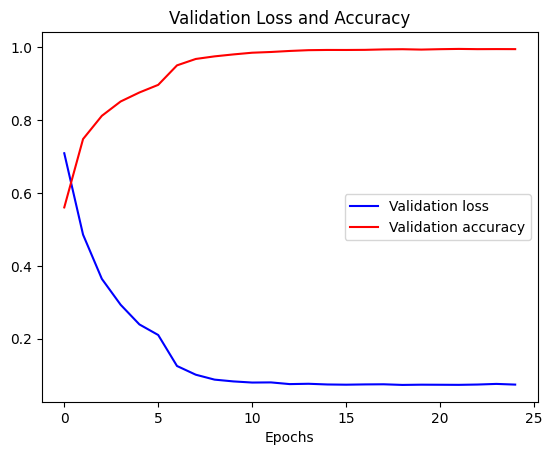

In [31]:
r"""Plotting validation loss and accuracy"""

x = range(0, len(loss_acc_iter3[0]))
y1 = loss_acc_iter3[2]
y2 = validation_accuracy

r"""loss_acc_iter3: training_loss, training_acc, validation_loss, validation_acc"""
plt.plot(x, y1, color='blue') #training loss
plt.plot(x, y2, color='red') #training accuracy
plt.title('Validation Loss and Accuracy') #title
plt.xlabel('Epochs') # x label
plt.legend(['Validation loss','Validation accuracy'])
plt.show()

In [90]:
current_loss = 0.0
current_corrects = 0

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    
    
    with torch.no_grad():
        model_iter3.eval()
        output = model_iter3(inputs)
        _, y_pred = torch.max(output, 1)
        y_pred = y_pred.cpu()
        labels = labels.cpu()
        test_loss = criterion(y_pred.float(), labels.float())

        current_corrects += torch.sum(y_pred == labels)

test_acc = current_corrects.double() / len(test_set)
        
print("Test accuracy is: {}%".format(test_acc*100))

Test accuracy is: 82.02000000000001%


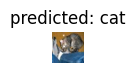

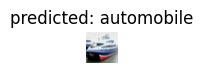

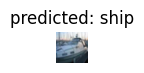

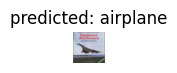

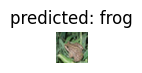

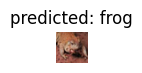

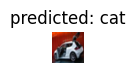

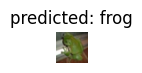

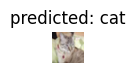

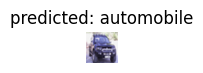

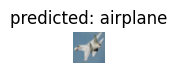

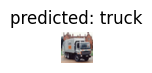

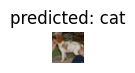

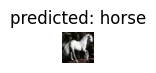

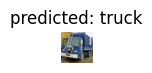

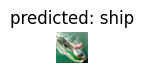

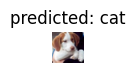

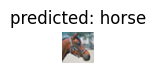

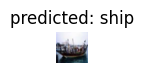

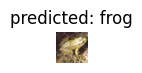

In [97]:
visualize_model(model_iter3, num_images = 20)
plt.show()

###### Model 4: Adam Optimizer with Gamma = 0.1, step_size = 7,lr=0.0001, weight_decay = 0.015, momentum_decay  = 0.0025

In [11]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(GoogLeNet.parameters(), lr=0.0001, weight_decay = 0.015, momentum_decay  = 0.0025)

decay_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [12]:
model_iter4, loss_acc_iter4 = train_model(GoogLeNet, criterion, optimizer, decay_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.2622 Acc: 0.5601
val Loss: 0.7123 Acc: 0.7652
Epoch 1/14
----------
train Loss: 0.7291 Acc: 0.7500
val Loss: 0.4841 Acc: 0.8462
Epoch 2/14
----------
train Loss: 0.5610 Acc: 0.8102
val Loss: 0.3787 Acc: 0.8794
Epoch 3/14
----------
train Loss: 0.4647 Acc: 0.8450
val Loss: 0.3209 Acc: 0.8978
Epoch 4/14
----------
train Loss: 0.3972 Acc: 0.8693
val Loss: 0.2857 Acc: 0.9160
Epoch 5/14
----------
train Loss: 0.3481 Acc: 0.8895
val Loss: 0.2575 Acc: 0.9246
Epoch 6/14
----------
train Loss: 0.1979 Acc: 0.9413
val Loss: 0.1288 Acc: 0.9680
Epoch 7/14
----------
train Loss: 0.1331 Acc: 0.9640
val Loss: 0.1063 Acc: 0.9750
Epoch 8/14
----------
train Loss: 0.1048 Acc: 0.9729
val Loss: 0.0923 Acc: 0.9784
Epoch 9/14
----------
train Loss: 0.0818 Acc: 0.9802
val Loss: 0.0836 Acc: 0.9792
Epoch 10/14
----------
train Loss: 0.0687 Acc: 0.9838
val Loss: 0.0798 Acc: 0.9794
Epoch 11/14
----------
train Loss: 0.0604 Acc: 0.9865
val Loss: 0.0773 Acc: 0.9810
Epoch 12/14
--

In [13]:
train_accuracy = []
for i in range(len(loss_acc_iter4[1])):
    loss_acc_iter4[1][i] = loss_acc_iter4[1][i].cpu()
    loss_acc_iter4[1][i] = loss_acc_iter4[1][i].numpy()
    train_accuracy.append(loss_acc_iter4[1][i])
train_accuracy

validation_accuracy = []
for i in range(len(loss_acc_iter4[3])):
    loss_acc_iter4[3][i] = loss_acc_iter4[3][i].cpu()
    loss_acc_iter4[3][i] = loss_acc_iter4[3][i].numpy()
    validation_accuracy.append(loss_acc_iter4[1][i])
validation_accuracy

[array(0.56006667),
 array(0.75),
 array(0.81024444),
 array(0.84497778),
 array(0.86933333),
 array(0.88946667),
 array(0.94133333),
 array(0.96404444),
 array(0.97293333),
 array(0.9802),
 array(0.98375556),
 array(0.98651111),
 array(0.98857778),
 array(0.99231111),
 array(0.99302222)]

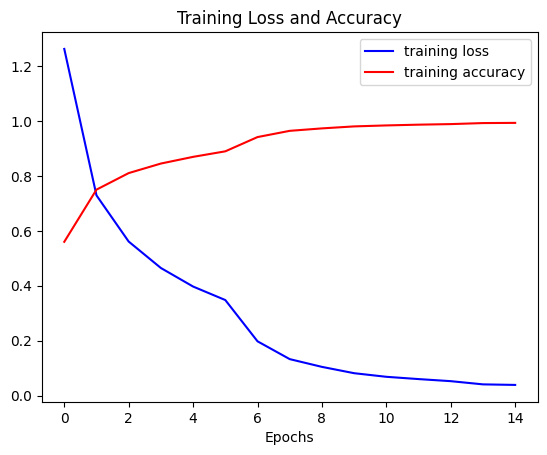

In [14]:
r"""Plotting validation loss and accuracy"""

x = range(0, len(loss_acc_iter4[0]))
y1 = loss_acc_iter4[0]
y2 = train_accuracy

r"""loss_acc_iter3: training_loss, training_acc, validation_loss, validation_acc"""
plt.plot(x, y1, color='blue') #training loss
plt.plot(x, y2, color='red') #training accuracy
plt.title('Training Loss and Accuracy') #title
plt.xlabel('Epochs') # x label
plt.legend(['training loss','training accuracy'])
plt.show()

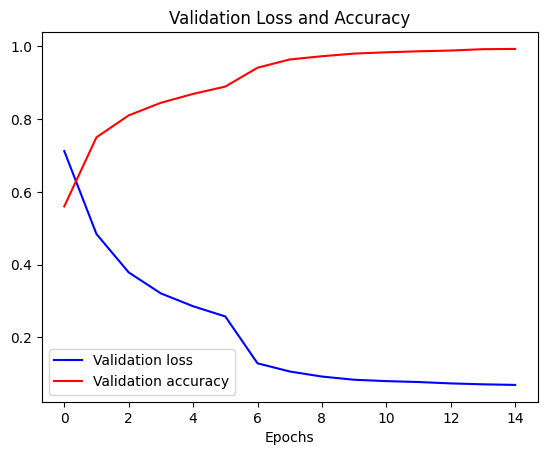

In [15]:
r"""Plotting validation loss and accuracy"""

x = range(0, len(loss_acc_iter4[0]))
y1 = loss_acc_iter4[2]
y2 = validation_accuracy

r"""loss_acc_iter3: training_loss, training_acc, validation_loss, validation_acc"""
plt.plot(x, y1, color='blue') #training loss
plt.plot(x, y2, color='red') #training accuracy
plt.title('Validation Loss and Accuracy') #title
plt.xlabel('Epochs') # x label
plt.legend(['Validation loss','Validation accuracy'])
plt.show()

In [16]:
current_loss = 0.0
current_corrects = 0

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        model_iter4.eval()
        output = model_iter4(inputs)
        _, y_pred = torch.max(output, 1)
        y_pred = y_pred.cpu()
        labels = labels.cpu()
        test_loss = criterion(y_pred.float(), labels.float())

        current_corrects += torch.sum(y_pred == labels)

test_acc = current_corrects.double() / len(test_set)
        
print("Test accuracy is: {}%".format(test_acc*100))

Test accuracy is: 82.43%


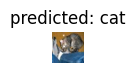

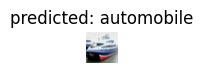

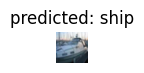

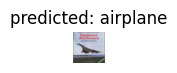

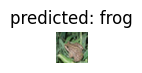

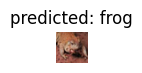

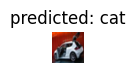

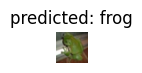

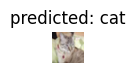

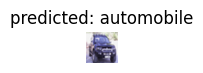

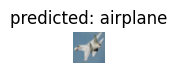

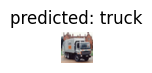

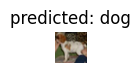

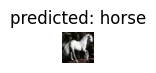

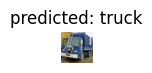

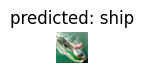

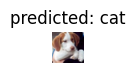

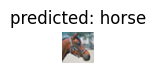

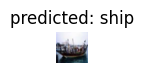

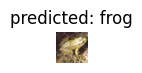

In [17]:
visualize_model(model_iter4, num_images = 20)
plt.show()

#### Confusion Matrix for best model

In [ ]:
tensor_cpu = tensor. to('cpu')

 
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    labels = labels.cpu()
    """Calculates the confusion matrix and F1 score."""
    y_pred = base_model(inputs).argmax(1)
    y_pred = y_pred.cpu()

    

cm = confusion_matrix(labels.detach().numpy(), y_pred.detach().numpy())
f1_score = f1_score(labels.numpy(), y_pred.numpy(), average='weighted')
print('Confusion Matrix:')
print(cm)
print('F1 Score: {:.4f}'.format(f1_score))
    